# McStas simulation exercise

In this exercise we will use the McStas Monte Carlo ray-tracing package with its python API McStasScript to simulate a powder diffraction instrument and analyze the resulting data. We will be looking at a simple crystal, lead, which has a textbook lattice constant of 4.92 Å and an FCC structure. The aim will be to calculate the lattice constant from the simulated data.

## McStas simulation
In this section we will set up our powder difractometer using McStas and the McStasScript python API.  

### Importing packages necessary for McStas simulations
First the McStasScript package is imported.

In [1]:
from mcstasscript.interface import instr, functions, plotter

### Setting up the instrument
Here an instrument object is created. All the files related to this instrument will be placed in the run_folder which must already exist. If no input_path is specified, the current directory will be used.

In [2]:
instrument = instr.McStas_instr("e_learning_exercise", input_path="run_folder")

### Adding a neutron source
The McStas simulation is described using components, the first component we will add describes the neutron source. We will use a component called *Source_simple*. One can ask the instrument object for help on the necessary parameters.

In [3]:
instrument.component_help("Source_simple")

 ___ Help Source_simple _____________________________________________________________
|optional parameter|required parameter|default value|user specified value|
radius = 0.1 [m] // Radius of circle in (x,y,0) plane where neutrons are 
                    generated. 
yheight = 0.0 [m] // Height of rectangle in (x,y,0) plane where neutrons are 
                     generated. 
xwidth = 0.0 [m] // Width of rectangle in (x,y,0) plane where neutrons are 
                    generated. 
dist = 0.0 [m] // Distance to target along z axis.
focus_xw = 0.045 [m] // Width of target
focus_yh = 0.12 [m] // Height of target
E0 = 0.0 [meV] // Mean energy of neutrons.
dE = 0.0 [meV] // Energy half spread of neutrons (flat or gaussian sigma).
lambda0 = 0.0 [AA] // Mean wavelength of neutrons.
dlambda = 0.0 [AA] // Wavelength half spread of neutrons.
flux = 1.0 [1/(s*cm**2*st*energy unit)] // flux per energy unit, Angs or meV if 
                                           flux=0, the source emits 1 in 4*

Here we set up an instance of *Source_simple* called *source* with our desired parameters. We would like to adjust the wavelength later, so we create an instrument parameter for this purpose. We make the source monochromatic.

In [4]:
src = instrument.add_component("source", "Source_simple")

# Physical description
src.xwidth = 0.08
src.yheight = 0.08

# Flux and wavelength range
instrument.add_parameter("wavelength", value=5.0, comment="Wavelength in [Ang]")
src.flux = 1E10
src.lambda0 = "wavelength"
src.dlambda = 0.01

# Monte carlo focusing (The source will generate rays targeting this rectangle)
src.focus_xw = 0.03
src.focus_yh = 0.04
src.dist = 0.5

### Adding optics
Next we add a straight guide that will transport neutrons from the source to our sample. The source use Monte Carlo focusing to only illuminate the entrance, so the opening and position of the guide is specified using these parameters from the source in order to avoid a mismatch.

In [5]:
guide = instrument.add_component("guide", "Guide_gravity", AT=[0, 0, src.dist], RELATIVE=src)
guide.w1 = src.focus_xw # guide opening width
guide.h1 = src.focus_yh # guide opening height
guide.w2 = src.focus_xw # guide end width
guide.h2 = src.focus_yh # guide end height
guide.l = 15.0  # guide length [m]
guide.m = 5.0   # coating quality
guide.G = -9.82 # gravity [m/s/s]

### Adding a powder sample 
Here we add a powder sample, it is a cylinder 4 cm in diameter and height. The data needed is in a datafile called Pb.laz, describing the powder Bragg peaks in lead. We place this sample 20 cm after the end of the guide.

In [6]:
sample = instrument.add_component("sample", "PowderN")
sample.radius = 0.02
sample.yheight = 0.04
sample.reflections = '"Pb.laz"'
sample.set_AT([0, 0, guide.l + 0.2], RELATIVE=guide)

### Adding a detector
Now we just need to measure the scattering pattern, and for this purpose we insert a banana monitor, which corresponds to part of a cylinder. We set coverage of scattering angle from 40 to 175 deg, and 1000 bins.

In [7]:
banana = instrument.add_component("banana", "Monitor_nD", RELATIVE=sample)
banana.xwidth = 2.0
banana.yheight = 0.3
banana.restore_neutron = 1
banana.filename = '"banana.dat"'
banana.options = '"theta limits=[40 175] bins=1000, banana"'

### Running the simulation
Now that we have defined a complete simulation, we can run it and obtain the data. The reader is encouraged to try the simulation with different simulated wavelengths to see what difference this makes.

In [8]:
simulation_wavelength = 3.0 # Change the wavelength here, recommended to keep it above 1.5 Å

data = instrument.run_full_instrument(ncount=1E7, foldername="data_folder/exercise",
                                      parameters={"wavelength" : simulation_wavelength},
                                      increment_folder_name=True)

INFO: Using directory: "/Users/madsbertelsen/PaNOSC/WP8/e-learning_notebook/data_folder/exercise_9"
INFO: Regenerating c-file: e_learning_exercise.c
CFLAGS=
INFO: Recompiling: ./e_learning_exercise.out
INFO: ===
INFO: Placing instr file copy e_learning_exercise.instr in dataset /Users/madsbertelsen/PaNOSC/WP8/e-learning_notebook/data_folder/exercise_9

      Opening input file '/Applications/McStas-2.5.app/Contents/Resources/mcstas/2.5/tools/Python/mcrun/../mccodelib/../../../data/Pb.laz' (Table_Read_Offset)
Table from file 'Pb.laz' (block 1) is 41 x 18 (x=1:9), constant step. interpolation: linear
  '# TITLE *-Pb-[FM3-M] Bouad, N.; Chapon, L.; Marin-Ayral, R.-M.; B[2003] [to ...'
PowderN: sample: Reading 41 rows from Pb.laz
PowderN: sample: Read 41 reflections from file 'Pb.laz'
PowderN: sample: Vc=121.29 [Angs] sigma_abs=0.684 [barn] sigma_inc=0.012 [barn] reflections=Pb.laz
Detector: banana_I=28412.4 banana_ERR=254.979 banana_N=73914 "banana.dat"



### Plotting the data
McStasScript has a plotter built in that can provide a quick overview of the simulated data. Here the scattered intensity as a function of the angle between the initial and final neutron direction.

number of elements in data list = 1
Plotting data with name banana


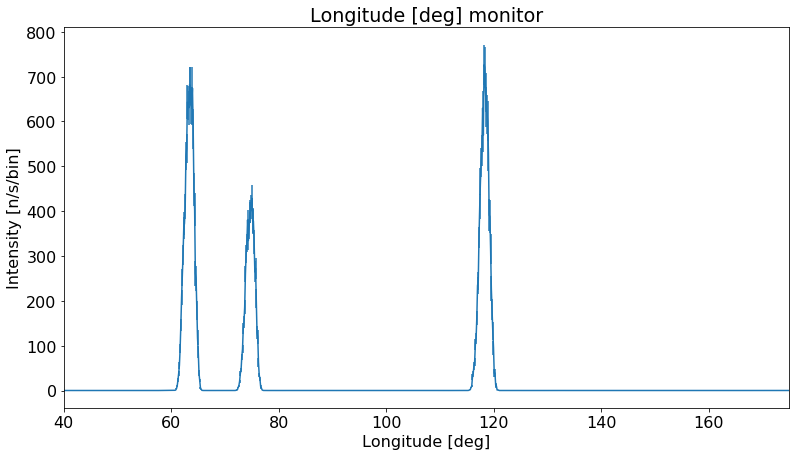

In [9]:
plotter.make_sub_plot(data, fontsize=16)

## Analysis of the data
In this section we will analyse the simulated data to ascertain the lattice constant for our material.

### Imporing the packages
In this section we use numpy to store data, matplotlib to plot and scipy for fitting. Its also convinient to set the standard figure size to something more suitable for a notebook.

In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import optimize

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100 

### Theory
The scattering we see from the powder is called Bragg scattering and is governed by Braggs law:

$n \lambda = 2d\sin(\theta)$

Here $\lambda$ is the wavelength, $d$ is the d-spacing and $\theta$ the scattering angle. In our simulation we directly set the wavelength, but measure double the scattering angle. We can transform our simulated data from $2\theta$ to $d$ using Braggs law, and then see peaks in d-spacing instead of $2\theta$.

Many Bragg peaks are available from a crystal lattice, each will have a d spacing, which is why several peaks can be seen. Each such peak can be identified with miller indices, which are vectors consisting of three integers. For cubic materials the lattice constant, d-spacing and length of the vector formed by the miller indices is related:

$a = d_{hkl}\left| hkl \right|$

Later we can use this relationship to identify the lattice constant of our material, but first we must identify the miller indices of our observed peaks along with their d spacing.

Text(0, 0.5, 'Intensity [n/s]')

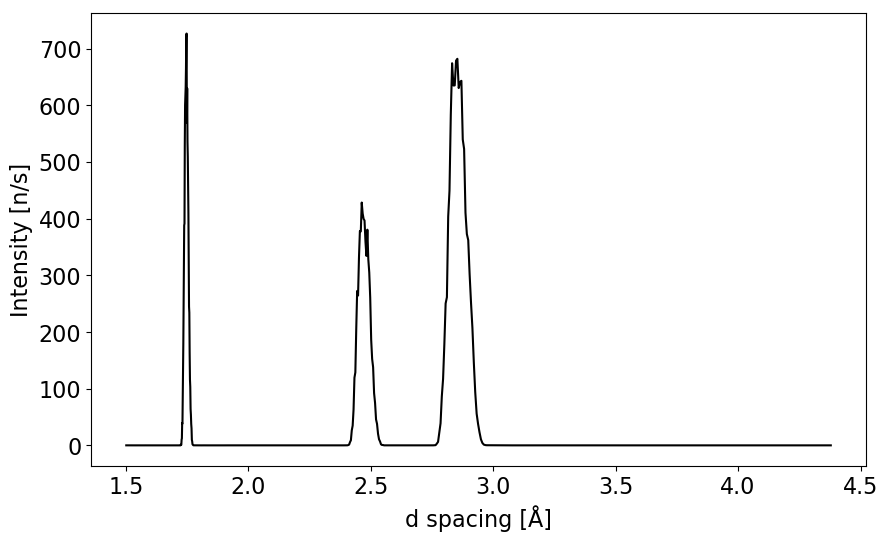

In [11]:
banana = functions.name_search("banana", data) # Grab McStasScript data object from our simulation data

Y_data = banana.Intensity # Get numpy array with intensity, likewise banana.xaxis has the scattering angle
X_data = simulation_wavelength/2.0/np.sin(np.deg2rad(0.5*banana.xaxis)) # transform to d spacing

plt.plot(X_data, Y_data, "k-")
plt.xlabel("d spacing [Å]", fontsize=16)
plt.ylabel("Intensity [n/s]", fontsize=16)

### FCC crystal
The crystal lattice for lead has what is called a face centered cubic structure (FCC). For a FCC crystal the miller indices must all be even or odd for a Bragg peak to be allowed and scattering can occur. This knowledge is helpful when identifying peaks in our data. Here we get an overview of the d spacing we can expect from the shortest hkl vectors. The miller indices of more reflections can be added to the list by the reader, if they are not included in the data the simulated wavelength can be reduced.

In [12]:
lattice = 4.92
allowed_hkl_list = [[1,1,1],
                    [2,0,0],
                    [2,2,0],
                    [3,1,1]]

for allowed_hkl in allowed_hkl_list:
    hkl = np.array(allowed_hkl)
    hkl_length = np.sqrt(np.sum(hkl**2))
    d_spacing = lattice/hkl_length
    print("hkl", hkl, " => d =", d_spacing)

hkl [1 1 1]  => d = 2.8405633244129587
hkl [2 0 0]  => d = 2.46
hkl [2 2 0]  => d = 1.7394826817189069
hkl [3 1 1]  => d = 1.483435815322597


### Fitting a gaussian to a Bragg peak
We now let the reader select a Bragg peak to fit with a gaussian. The model and error function is defined, and then a guess needs to be made. The guess on the center location of the peak has been set to 0, causing the fit to fail. The reader can update this to a available peak with known miller indices.

The fit is performed and a plot of the guess, data and fitted curve is displayed.

[600, 0, 0.03]
[6.e+02 0.e+00 3.e-02]


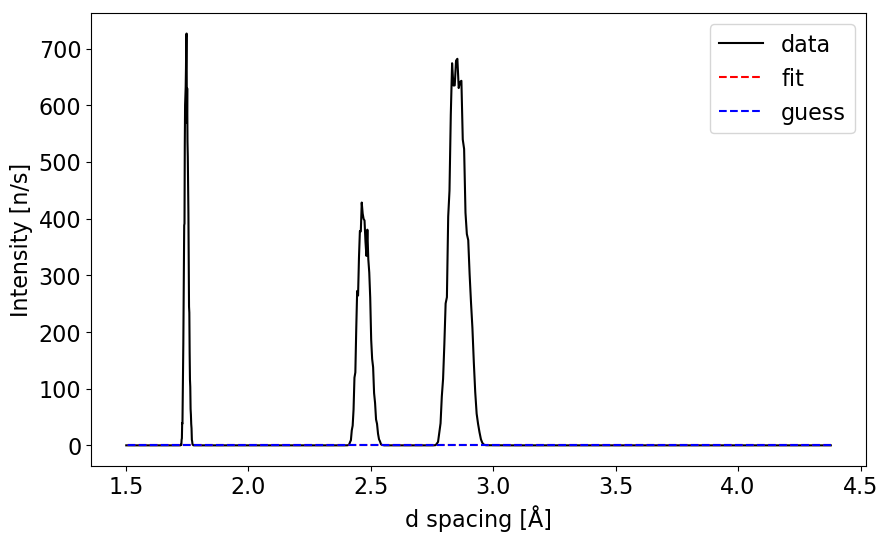

In [13]:
model = lambda p, x: p[0]*np.exp(-((x - p[1])/p[2])**2) # Target function (gaussian)
errfunc = lambda p, x, y: model(p, x) - y # Distance to the target function

guess = [600, 0, 0.03] # guess: [height, center, width]
pars, success = optimize.leastsq(errfunc, guess[:], args=(X_data, Y_data)) # Fit

# Plot of data, fit and guess
plt.plot(X_data, Y_data, "k-",
         X_data, model(pars, X_data), "r--",
         X_data, model(guess, X_data), "b--")

plt.xlabel("d spacing [Å]", fontsize=16)
plt.ylabel("Intensity [n/s]", fontsize=16)
#plt.xlim([2.0, 3.0]) # Zoom in on x axis if required

plt.legend(["data", "fit", "guess"])

print(guess)
print(pars)

### Calculate lattice constant from fit result
From the fitted d-spacing and knowledge of the miller indices we can calculate the lattice spacing $a = d_{hkl}\left| hkl \right|$. Here the miller indices have been left as zeros, the reader should insert the miller indices corresponding to the fitted peak to get the right result.

In [14]:
hkl = np.array([0, 0, 0]) # insert the miller indices of the investigated peak here
hkl_length = np.sqrt(np.sum(hkl)**2)

calculated_lattice = (pars[1]*hkl_length)
print("Calculated lattice constant from fit:", calculated_lattice)

Calculated lattice constant from fit: 0.0


The lattice constant used in the simulated data is slightly different from the textbook value, so do not be concerned if it does not match exactly. The difference should however be less than 2%.